# Tarea 6

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bccr import SW
from statsmodels.formula.api import ols

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 250
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'

### Inciso a

In [2]:
imae =SW(nivel=35553)

imae["log_imae"] = np.log(imae.nivel)

### Inciso b

In [4]:
t = [i for i in range(1, 360)]
imae["t"] = t
imae["D"] = (imae.index >= "2020-03").astype(int)

res = ols('log_imae ~ t + D', data=imae).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_imae   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 2.591e+04
Date:                Sun, 20 Jun 2021   Prob (F-statistic):               0.00
Time:                        22:13:31   Log-Likelihood:                 813.11
No. Observations:                 359   AIC:                            -1620.
Df Residuals:                     356   BIC:                            -1609.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8300      0.003   1416.869      0.000       3.825       3.835
t              0.0030   1.33e-05    222.841      0.000       0.003       0.003
D             -0.1388      0.009    -15.682      0.000      -0.156      -0.121
==============================================================================
Omnibus:                       34.736   Durbin-Watson:                   0.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.510
Skew:                           0.453   Prob(JB):                     3.66e-20
Kurtosis:                       5.273   Cond. No.                     1.38e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Asumiendo que se cumple los supuestos del modelo clásico de regresión lineal, $\delta$ sí es significativo. Como p-value es menor que 0.01, se rechaza la hipótesis nula de que $\delta = 0$ a un nivel de significancia del 1%. 

Se estimó un modelo log-lineal. Por tanto, $\delta = -0.1388$ indica que, en promedio, el IMAE mensual es 13.88% menor a partir de marzo 2020.

### Inciso c

In [5]:
def ZivotAndrewsA(serie, k=8):
    dta = imae[[serie]].dropna()
    dta.rename(columns={serie:'y'}, inplace=True)
    dta['t'] = np.arange(dta.shape[0])
    dta['Ly'] = dta['y'].shift(1)
    dta['Dy'] = dta['y'].diff(1)
    for j in range(1, k+1):
        dta[f'D{j}y'] = dta['Dy'].shift(j)    

    lags = '+'.join(dta.columns[-k:])

    alpha1values = pd.Series(0.0, index=dta.index)

    for tau in alpha1values.index:
        dta['DL'] = (dta.index>tau).astype(int)
        modelo = ols('y ~ Ly + t + DL + ' + lags, dta).fit()
        alpha1values[tau] = ((modelo.params - 1)/modelo.bse)['Ly']

    tauhat, tval = alpha1values.idxmin(), alpha1values.min()
    dta['DL'] = (dta.index>tauhat).astype(int)
    modelo = ols('y ~ Ly + t + DL + ' + lags, dta).fit()

    return {r'$\hat{T}_B$':tauhat, r'$\alpha_1$': np.round(modelo.params['Ly'],3), r'$t$': np.round(tval,2)}

In [6]:
for i in range(1, 9):
    print("Cantidad de rezagos: " + str(i))
    print(ZivotAndrewsA("log_imae", k=i), "\n")

Cantidad de rezagos: 1
{'$\\hat{T}_B$': Period('2020-02', 'M'), '$\\alpha_1$': 0.958, '$t$': -4.42} 

Cantidad de rezagos: 2
{'$\\hat{T}_B$': Period('2020-02', 'M'), '$\\alpha_1$': 0.956, '$t$': -4.58} 

Cantidad de rezagos: 3
{'$\\hat{T}_B$': Period('2020-02', 'M'), '$\\alpha_1$': 0.955, '$t$': -4.65} 

Cantidad de rezagos: 4
{'$\\hat{T}_B$': Period('2020-02', 'M'), '$\\alpha_1$': 0.954, '$t$': -4.66} 

Cantidad de rezagos: 5
{'$\\hat{T}_B$': Period('2020-02', 'M'), '$\\alpha_1$': 0.953, '$t$': -4.63} 

Cantidad de rezagos: 6
{'$\\hat{T}_B$': Period('2020-02', 'M'), '$\\alpha_1$': 0.953, '$t$': -4.57} 

Cantidad de rezagos: 7
{'$\\hat{T}_B$': Period('2020-02', 'M'), '$\\alpha_1$': 0.953, '$t$': -4.45} 

Cantidad de rezagos: 8
{'$\\hat{T}_B$': Period('2020-02', 'M'), '$\\alpha_1$': 0.954, '$t$': -4.25} 



<center><b>Prueba de Zivot y Andrews (modelo A): valores crítico</b></center>

|1%|5%|10%|
|---|---|---|
|-5.34|-4.80|-4.58|

Se realizó la prueba de Zivot y Andrews para distintas cantidades de rezagos. Para todas las pruebas no se puede rechazar, a un niveles de significancia de 1% o 5%, la hipótesis nula de que la serie del logaritmo del IMAE se comporte como un proceso AR(1). Por tanto, según esta prueba, no hay evidencia de que exista un cambio estructural. Sin embargo, la prueba detecta que la fecha más plausible de que exista un cambio estructural es febrero 2020.

## Inciso d

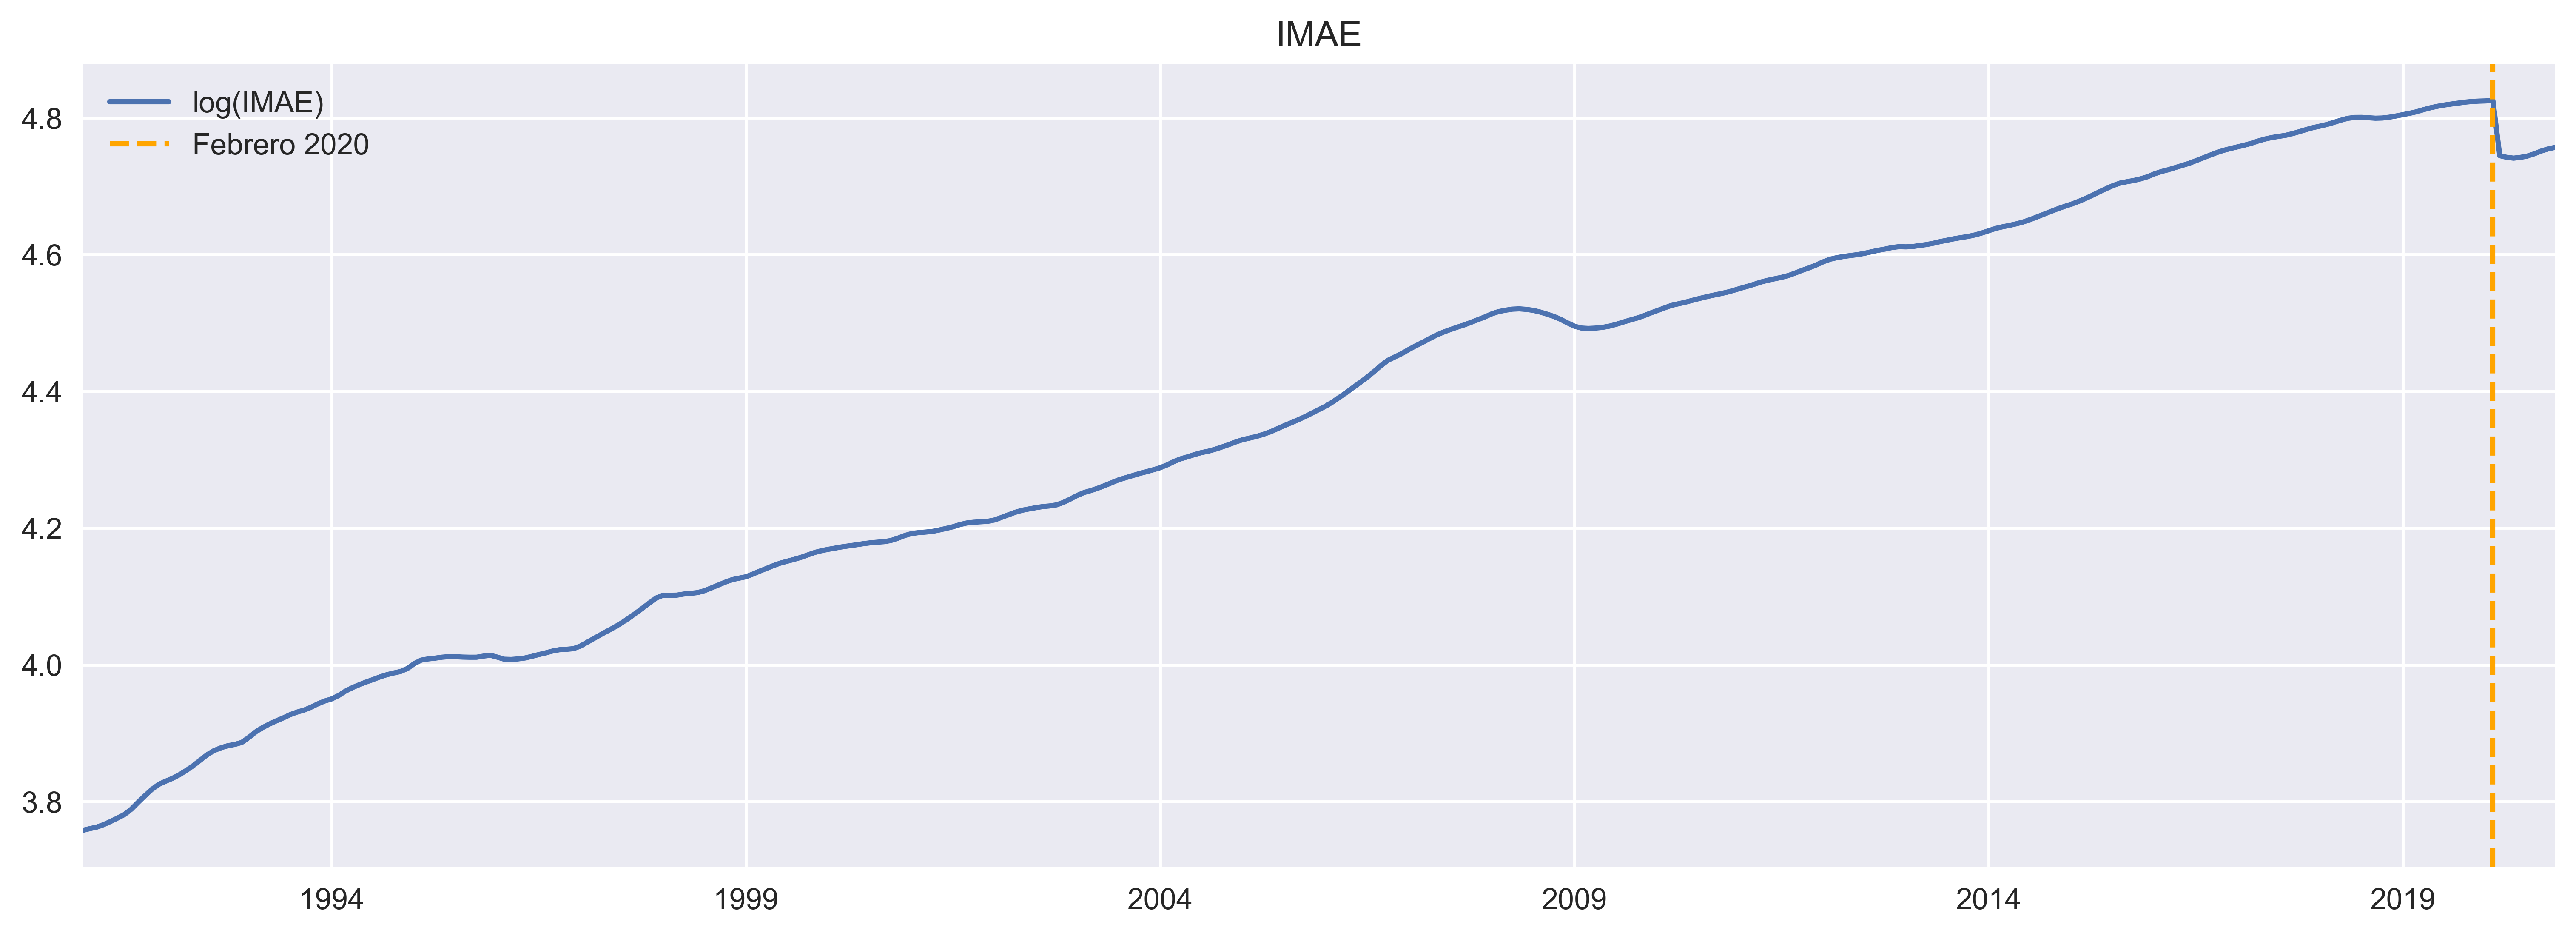

In [8]:
fig, ax =plt.subplots(figsize=(15,5))
ax = imae.log_imae.plot(ax=ax, label= "log(IMAE)")
ax.axvline(x="2020-02", ls="--", color='orange', label="Febrero 2020")
ax.set_title("IMAE")
plt.xlabel("")
plt.ylabel("")
plt.legend()

El resultado de Zivot y Andrews no fue el esperado. Por las medidas sanitarias ante el COVID-19 la caída de actividad económica fue drástica, como muestra el gráfico anterior. Entonces, se esperaba encontrar un cambio estructural.

Por otra parte, nótese que la prueba detecta acertadamente que el momento más plausible para un cambio estructural es febrero 2020. Es posible que la distribución de cantidad de datos antes y después de esa fecha impidiera rechazar la hipótesis nula, pues para todas las pruebas la cantidad de observaciones antes del febrero 2020 representan más del 95%.